## 01_cleaning
  

**Download the data from Chicago Data Portal and clean it**  

* The notebook creates a couple of local intermediate data files in tmp folder, that can be ignored


In [ ]:
!pip install klib

In [ ]:
import pandas as pd
import numpy as np
import klib
from platform import python_version

%precision 2
pd.set_option('display.precision',2)
pd.set_option('display.float_format','{:,.4f}'.format)

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)

python 3.10.12
numpy 1.25.2
pandas 2.0.3
klib 1.1.2


# Download source data

The sequence of notebooks start from the direct raw download of data from the chicago data portal.

We worked with a snapshot downloaded on 2021-02-28, but the whole process is expected to be re-executable without any issues as in later stages we filter down the working data to just include the years of 2018,2019,2020, which are all in the past so we don't expect them to change.


We kept the download code commented out to prevent slowing down the process since we already had local copies.

# Read CSV file

In [ ]:
df_raw = pd.read_csv('/content/sample_data/TrafficCrashes.csv').reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820587 entries, 0 to 820586
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                820587 non-null  object 
 1   CRASH_DATE_EST_I               61330 non-null   object 
 2   CRASH_DATE                     820587 non-null  object 
 3   POSTED_SPEED_LIMIT             820587 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         820587 non-null  object 
 5   DEVICE_CONDITION               820587 non-null  object 
 6   WEATHER_CONDITION              820587 non-null  object 
 7   LIGHTING_CONDITION             820587 non-null  object 
 8   FIRST_CRASH_TYPE               820587 non-null  object 
 9   TRAFFICWAY_TYPE                820587 non-null  object 
 10  LANE_CNT                       199010 non-null  float64
 11  ALIGNMENT                      820587 non-null  object 
 12  ROADWAY_SURFACE_COND          

GridSpec(6, 6)

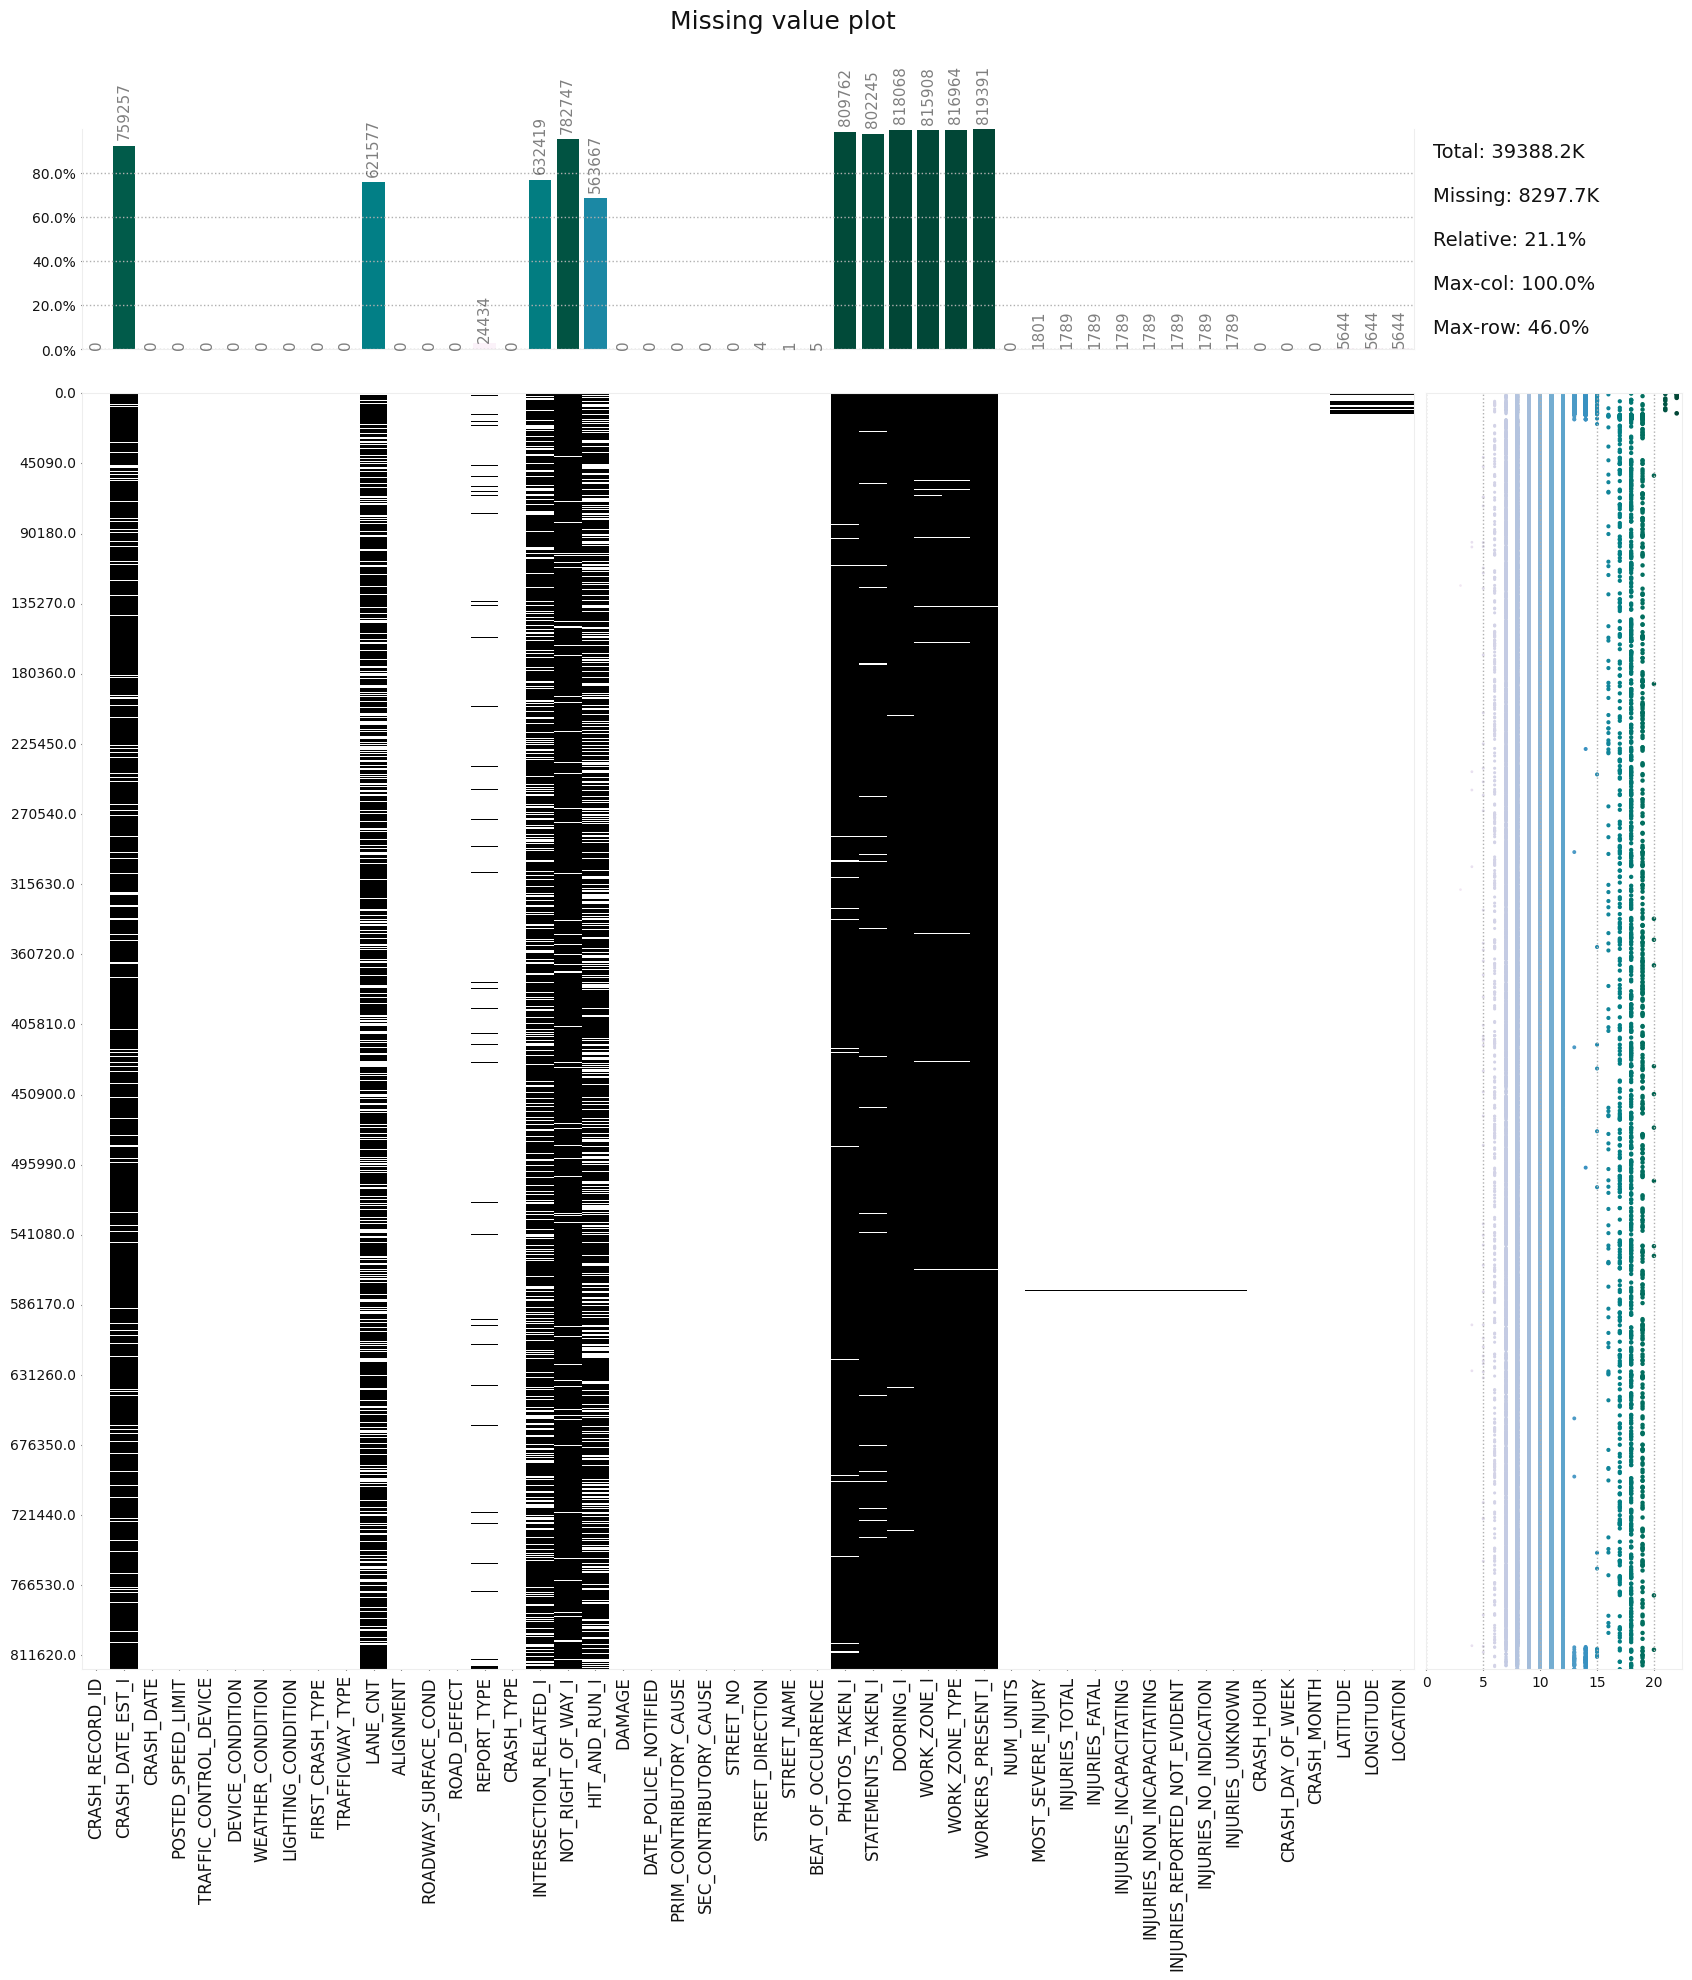

In [ ]:
klib.missingval_plot(df_raw)

In [ ]:
# Rename long columns
df_1 = df_raw.rename(columns={
    'INJURIES_NON_INCAPACITATING': 'INJ_NON_INCAP',
    'INJURIES_REPORTED_NOT_EVIDENT': 'INJ_REPORT_NOT_EVDNT'
})

# Drop unwanted columns
df_1.drop(columns=[
     'CRASH_DATE_EST_I', 'LANE_CNT', 'LOCATION', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
    'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'
], inplace=True)


In [ ]:
# Clean and standardize column names
df_c = klib.clean_column_names(df_1)

GridSpec(6, 6)

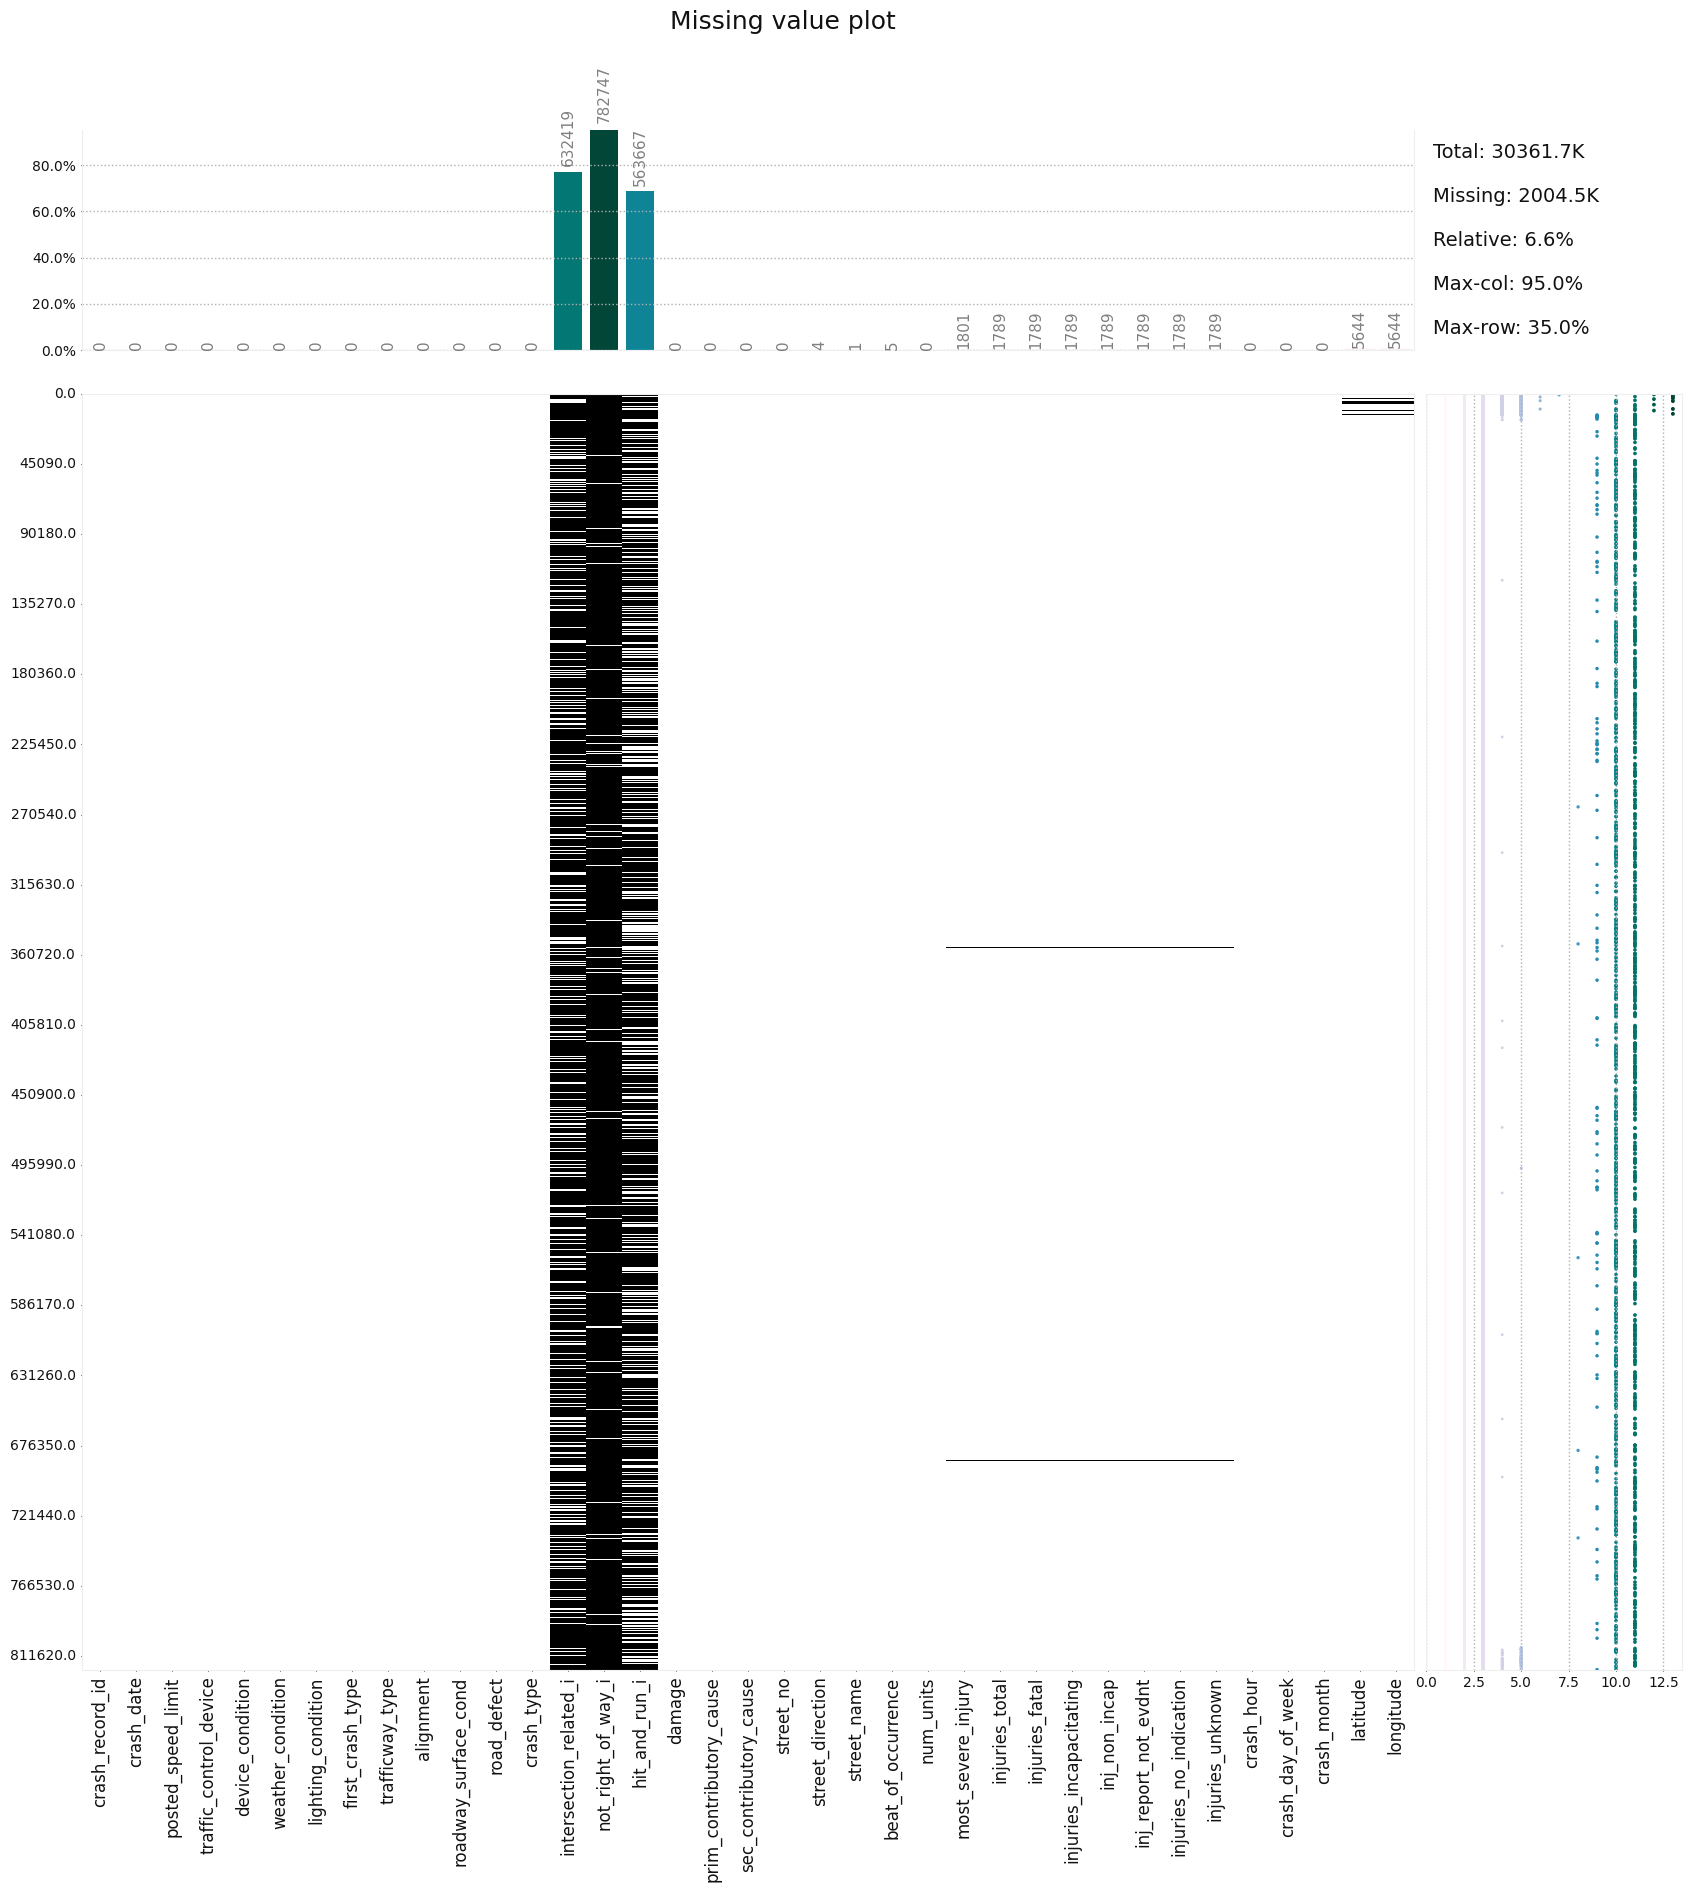

In [ ]:
klib.missingval_plot(df_c)

In [ ]:
# Fill missing values in these columns with N value, assuming it's the default
df_c.fillna({
    'intersection_related_i':'N',
    'not_right_of_way_i':'N',
    'hit_and_run_i':'N'
}, inplace=True)

GridSpec(6, 6)

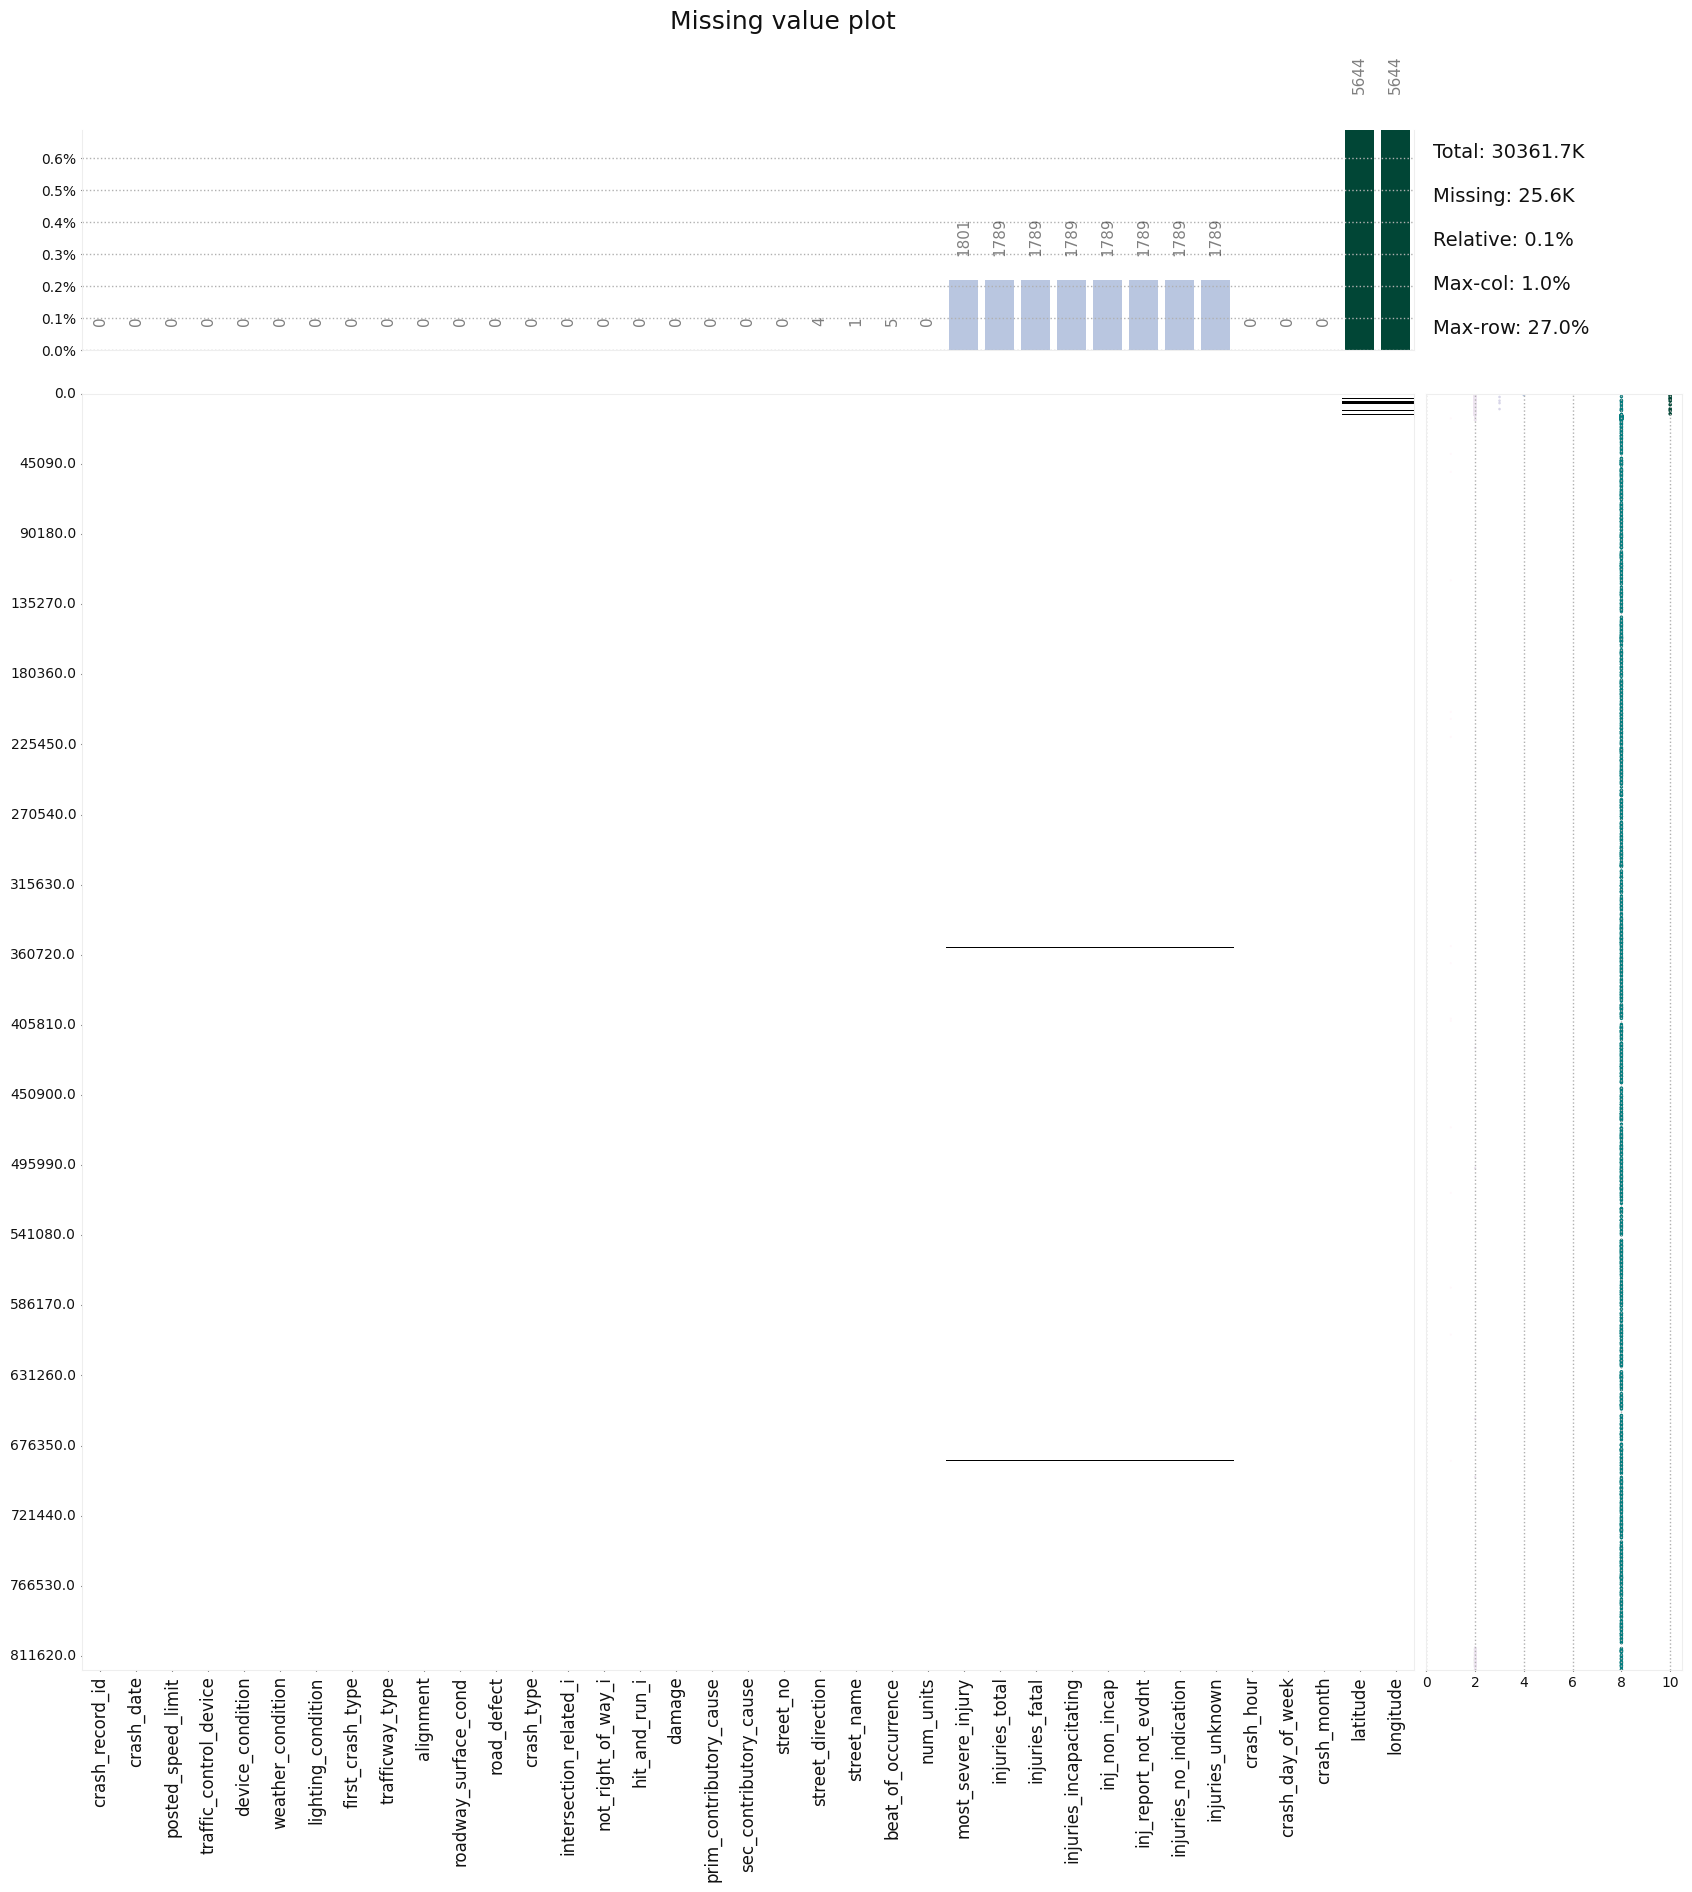

In [ ]:
klib.missingval_plot(df_c)

In [ ]:
# Set these columns to 0 wherever injuries_total is missing and crash_type is no injury
df_c.loc[((df_c.injuries_total.isna()) & (df_c.crash_type == 'NO INJURY / DRIVE AWAY')),[
          'injuries_total',
          'injuries_fatal',
          'injuries_incapacitating',
          'inj_non_incap',
          'inj_report_not_evdnt',
          'injuries_no_indication',
          'injuries_unknown'
         ]] = 0

In [ ]:
# Drop rows where injuries_total is missing
df_c.drop(df_c[df_c.injuries_total.isna()].index, inplace=True)

In [ ]:
# Set most_severe_injury = NO INDICATION OF INJURY,
# wherever most_severe_injury is missing and injuries_total is 0
df_c.loc[(df_c.most_severe_injury.isna()) & (df_c.injuries_total == 0),'most_severe_injury'] = 'NO INDICATION OF INJURY'

In [ ]:
df_c.most_severe_injury.value_counts(dropna=False)

most_severe_injury
NO INDICATION OF INJURY     706841
NONINCAPACITATING INJURY     63696
REPORTED, NOT EVIDENT        34513
INCAPACITATING INJURY        13852
FATAL                          902
Name: count, dtype: int64

GridSpec(6, 6)

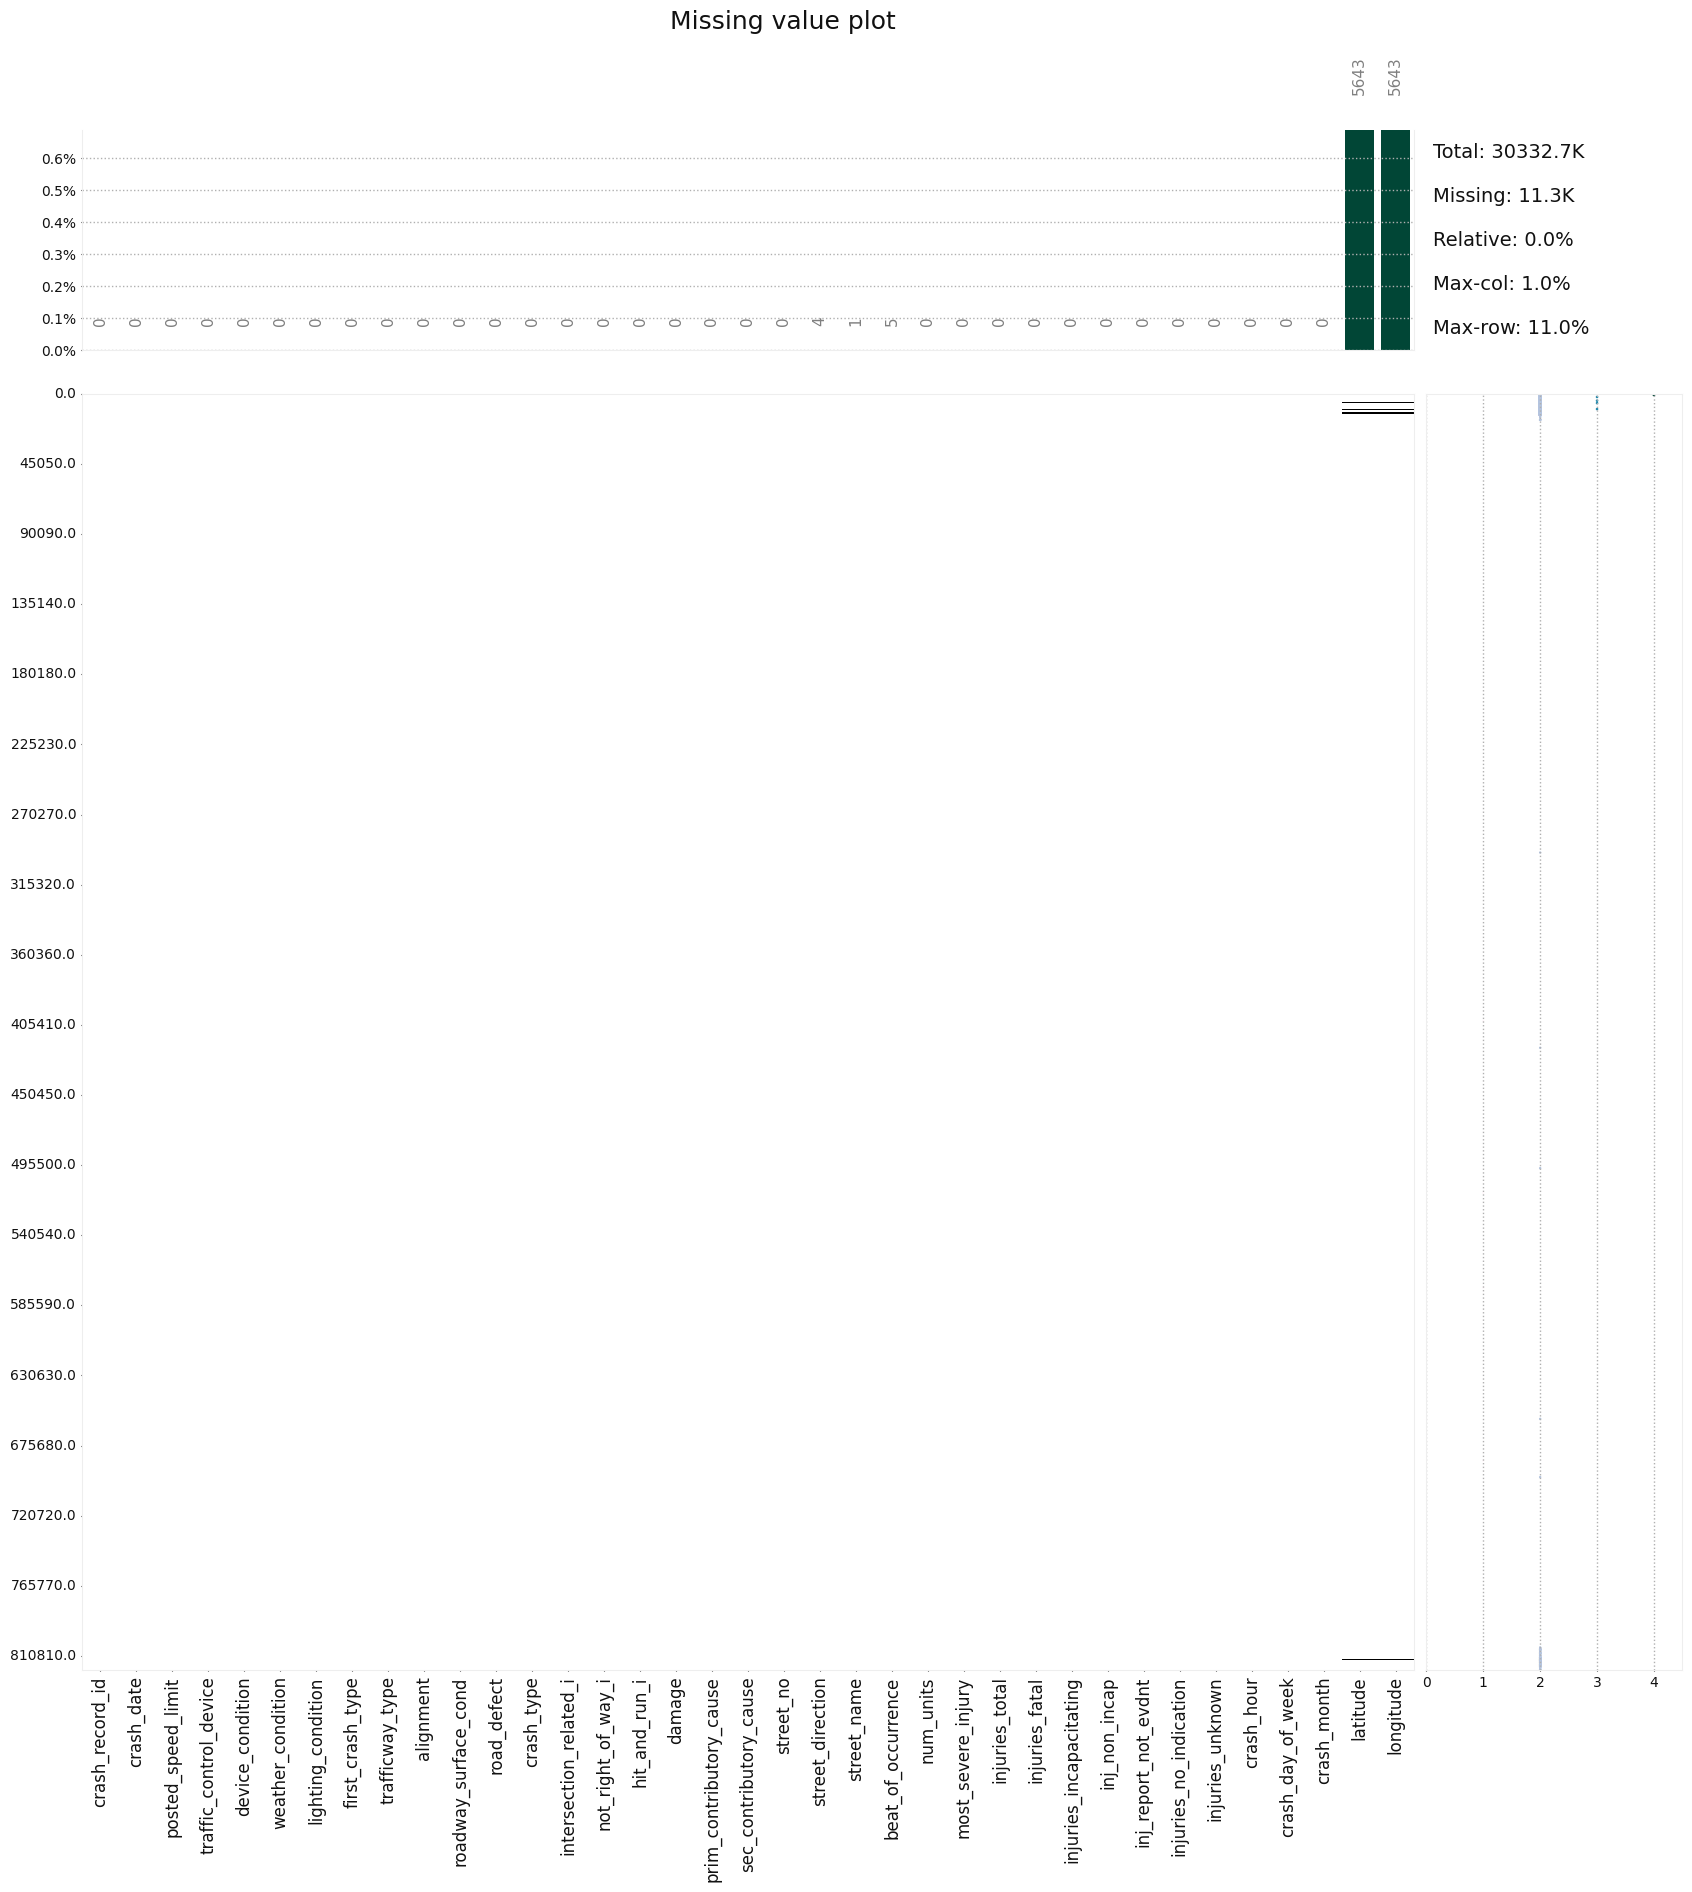

In [ ]:
klib.missingval_plot(df_c)

In [ ]:
# Fill missing beats

#df_c.loc[240890,'beat_of_occurrence'] = 712
#df_c.loc[304891,'beat_of_occurrence'] = 312
#df_c.loc[340159,'beat_of_occurrence'] = 1711

# Decided to drop records with missing beats. Not worth the step

In [ ]:
import pandas as pd

# Ensure 'crash_date' is a datetime object
df_c['crash_date'] = pd.to_datetime(df_c['crash_date'])

# Create 'crash_year' column from 'crash_date'
df_c['crash_year'] = df_c['crash_date'].dt.year

# Convert 'street_no', 'street_direction', and 'street_name' to string
df_c['street_no'] = df_c['street_no'].astype(str)
df_c['street_direction'] = df_c['street_direction'].astype(str)
df_c['street_name'] = df_c['street_name'].astype(str)

# Create 'address' column by concatenating the street address components
df_c['address'] = df_c[['street_no', 'street_direction', 'street_name']].agg(' '.join, axis=1)


In [ ]:
# I will not drop duplicates, as they represent repeated incident characteristics, I think it's useful
df_c2 = klib.data_cleaning(df_c, drop_duplicates=False)

Shape of cleaned data: (819804, 38) - Remaining NAs: 11291


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 1
     of which 1 single valued.     Columns: ['injuries_unknown']
Dropped missing values: 0
Reduced memory by at least: 201.48 MB (-72.13%)



In [ ]:
# drop rows that have both long and lat == 0
df_c2 = df_c2.query('latitude != 0 and longitude !=0')

In [ ]:
# At this point, Drop any rows that still has NA's
df_c2.dropna(axis=0, inplace=True)

In [ ]:
# Fix floats that should be int after we got rid of NA values
df_c2.beat_of_occurrence = df_c2.beat_of_occurrence.astype(int)
df_c2.injuries_total = df_c2.injuries_total.astype(int)
df_c2.injuries_fatal = df_c2.injuries_fatal.astype(int)
df_c2.injuries_incapacitating = df_c2.injuries_incapacitating.astype(int)
df_c2.inj_non_incap = df_c2.inj_non_incap.astype(int)
df_c2.inj_report_not_evdnt = df_c2.inj_report_not_evdnt.astype(int)
df_c2.injuries_no_indication = df_c2.injuries_no_indication.astype(int)


In [ ]:
df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814109 entries, 1 to 820586
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_record_id          814109 non-null  string        
 1   crash_date               814109 non-null  datetime64[ns]
 2   posted_speed_limit       814109 non-null  int8          
 3   traffic_control_device   814109 non-null  category      
 4   device_condition         814109 non-null  category      
 5   weather_condition        814109 non-null  category      
 6   lighting_condition       814109 non-null  category      
 7   first_crash_type         814109 non-null  category      
 8   trafficway_type          814109 non-null  category      
 9   alignment                814109 non-null  category      
 10  roadway_surface_cond     814109 non-null  category      
 11  road_defect              814109 non-null  category      
 12  crash_type           

In [ ]:
klib.missingval_plot(df_c2)

No missing values found in the dataset.


In [ ]:
df_c2

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,inj_non_incap,inj_report_not_evdnt,injuries_no_indication,crash_hour,crash_day_of_week,crash_month,latitude,longitude,crash_year,address
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,2023-07-29 14:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,0,0,1,14,7,7,41.8541,-87.6659,2023,2101 S ASHLAND AVE
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,2023-08-18 17:58:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,1,0,1,17,6,8,41.9430,-87.7619,2023,3422 N LONG AVE
13,fd05285e9d273fe20cbbebf84794045828a2ba589073b6...,2023-07-29 14:30:00,10,NO CONTROLS,NO CONTROLS,UNKNOWN,UNKNOWN,ANGLE,PARKING LOT,STRAIGHT AND LEVEL,...,0,0,2,14,7,7,41.8098,-87.5942,2023,1320 E 47TH ST
14,fda2491d33ac819033f4aaa7ed901120f2f6785b7e5bbb...,2023-07-29 00:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DARKNESS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,2,0,7,7,41.8992,-87.6966,2023,999 N CALIFORNIA AVE
20,161ff459c7fff8e1359204d1c54db502674fdfbf7036a9...,2023-09-20 12:57:00,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,STRAIGHT AND LEVEL,...,0,0,2,12,4,9,41.7442,-87.5859,2023,8300 S STONY ISLAND AVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820582,f2c0204e5392ff379e5804ad25fad66304949d517327c6...,2020-10-18 00:03:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,4,0,1,10,41.7762,-87.7032,2020,6432 S KEDZIE AVE
820583,6b6f5ceb4053bfbb3483fb453231caa94ff2351bde4c9d...,2019-10-23 13:32:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT ON GRADE,...,0,0,0,13,4,10,41.7510,-87.6254,2019,20 W 79TH ST
820584,bfa8377168b8dc75b4a09bf627b4e28fc77f465911c99b...,2023-09-13 13:08:00,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,TURNING,FOUR WAY,STRAIGHT AND LEVEL,...,0,0,2,13,4,9,41.9239,-87.6374,2023,320 W BELDEN AVE
820585,376bbadc3c632b81e0185fb1a3ddeed6c0dd52ebb8b3a9...,2019-10-13 01:40:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,2,1,1,10,41.9241,-87.6992,2019,2357 N MILWAUKEE AVE


# Write final DF to csv

In [ ]:
df_c2.to_csv('/content/sample_data/TC.csv')

In [ ]:
crash_df = pd.read_csv('/content/sample_data/TC.csv')

In [ ]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814109 entries, 0 to 814108
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               814109 non-null  int64  
 1   crash_record_id          814109 non-null  object 
 2   crash_date               814109 non-null  object 
 3   posted_speed_limit       814109 non-null  int64  
 4   traffic_control_device   814109 non-null  object 
 5   device_condition         814109 non-null  object 
 6   weather_condition        814109 non-null  object 
 7   lighting_condition       814109 non-null  object 
 8   first_crash_type         814109 non-null  object 
 9   trafficway_type          814109 non-null  object 
 10  alignment                814109 non-null  object 
 11  roadway_surface_cond     814109 non-null  object 
 12  road_defect              814109 non-null  object 
 13  crash_type               814109 non-null  object 
 14  inte

# Extra Steps

TODO
* [x] Round posted_speed_limit to nearest 5th unit
* [x] Create columns has_injuries and fatalaties
* [x] Drop date_police_notified (done at the top of the notebook)
* [x] Descretize crash_hour into  bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening']

In [ ]:
_unit = 5 # rounding at mid-point to nearest _unit
crash_df.posted_speed_limit = crash_df.posted_speed_limit.apply(lambda x: (x//_unit*_unit) + round(x%_unit/_unit)*_unit)
crash_df.posted_speed_limit.value_counts()

posted_speed_limit
30     601084
35      54363
25      51332
20      33337
15      28598
10      18971
40       7846
0        7469
45       5250
5        4857
55        649
50        224
100        66
60         43
65         15
70          5
Name: count, dtype: int64

In [ ]:
crash_df['has_injuries'] = crash_df.injuries_total.apply(lambda x: int(x>0))
crash_df['has_injuries'].value_counts()

has_injuries
0    701859
1    112250
Name: count, dtype: int64

In [ ]:
crash_df['has_fatal'] = crash_df.injuries_fatal.apply(lambda x: int(x>0))
crash_df['has_fatal'].value_counts()

has_fatal
0    813213
1       896
Name: count, dtype: int64

In [ ]:
crash_df['crash_time_of_day'] = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])
crash_df['crash_time_of_day'].value_counts()

crash_time_of_day
mid_day      339924
morning      241005
evening      138796
overnight     94384
Name: count, dtype: int64

# Write custom DF to csv

This is the data frame that has newly created featured and transformed values

In [ ]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day',
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
    'street_no',
    'street_direction',
    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units'
]

target_names = [
    'has_injuries',
    'has_fatal', 
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal'
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'street_no',
 'street_direction',
 'street_name',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [ ]:
file_crash_df = '/content/sample_data/crash_df.csv'

In [ ]:
crash_df[all_columns].to_csv(file_crash_df)

# Read the clean data and select only the required features

In [ ]:
crash_df = pd.read_csv('/content/sample_data/crash_df.csv')

In [ ]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814109 entries, 0 to 814108
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               814109 non-null  int64  
 1   crash_date               814109 non-null  object 
 2   crash_year               814109 non-null  int64  
 3   crash_month              814109 non-null  int64  
 4   crash_day_of_week        814109 non-null  int64  
 5   crash_hour               814109 non-null  int64  
 6   crash_time_of_day        814109 non-null  object 
 7   latitude                 814109 non-null  float64
 8   longitude                814109 non-null  float64
 9   beat_of_occurrence       814109 non-null  int64  
 10  address                  814109 non-null  object 
 11  street_no                814109 non-null  int64  
 12  street_direction         814108 non-null  object 
 13  street_name              814109 non-null  object 
 14  post

In [ ]:
crash_features = crash_df[features_names]
crash_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814109 entries, 0 to 814108
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   crash_date               814109 non-null  object 
 1   crash_year               814109 non-null  int64  
 2   crash_month              814109 non-null  int64  
 3   crash_day_of_week        814109 non-null  int64  
 4   crash_hour               814109 non-null  int64  
 5   crash_time_of_day        814109 non-null  object 
 6   latitude                 814109 non-null  float64
 7   longitude                814109 non-null  float64
 8   beat_of_occurrence       814109 non-null  int64  
 9   address                  814109 non-null  object 
 10  street_no                814109 non-null  int64  
 11  street_direction         814108 non-null  object 
 12  street_name              814109 non-null  object 
 13  posted_speed_limit       814109 non-null  int64  
 14  traf

In [ ]:
crash_targets = crash_df[target_names]
crash_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814109 entries, 0 to 814108
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   has_injuries    814109 non-null  int64 
 1   has_fatal       814109 non-null  int64 
 2   crash_type      814109 non-null  object
 3   damage          814109 non-null  object
 4   injuries_total  814109 non-null  int64 
 5   injuries_fatal  814109 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 37.3+ MB
